In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
PATH = 'data/New_DB.xlsx'
df = pd.read_excel(PATH)

In [3]:
columns =['slope', 'PP', 'valor_humedad_suelo1']
X = df.loc[:,columns]

In [4]:
df_general = X
n_df_general = X * 0.9
df_general['output'] = 1
n_df_general['output'] = 0

df_output = pd.concat([df_general, n_df_general])

In [5]:
df_output.isnull().sum()

slope                     2
PP                        0
valor_humedad_suelo1    276
output                    0
dtype: int64

In [6]:
X_slope_PP = df_output.drop('valor_humedad_suelo1', axis=1)
X_slope_PP_vhs1 = df_output

In [7]:
X_slope_PP = X_slope_PP.dropna()
X_slope_PP_vhs1 = X_slope_PP_vhs1.dropna()
X_slope_PP = X_slope_PP.reset_index(drop=True)
X_slope_PP_vhs1 = X_slope_PP_vhs1.reset_index(drop=True)

In [8]:
X_slope_PP.shape, X_slope_PP_vhs1.shape

((832, 3), (558, 4))

In [9]:
y_slope_PP = X_slope_PP.output
X_slope_PP = X_slope_PP.drop(labels='output', axis=1)

y_slope_PP_vhs1 = X_slope_PP_vhs1.output
X_slope_PP_vhs1 = X_slope_PP_vhs1.drop(labels='output', axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pytensor
import pytensor.tensor as pt
# TODO:
#   Separar el train con y sin vhs y definir correctamente nombre de variables
#   Intentar formato floatX de la forma:
#                                       floatX = pytensor.config.floatX
#                                       "X.astype(floatX)"
sc = StandardScaler()
floatX = pytensor.config.floatX
X_slope_PP_vhs1 = X_slope_PP_vhs1.astype(floatX)
y_slope_PP_vhs1 = y_slope_PP_vhs1.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
random_seed = 12
rng = np.random.default_rng(random_seed)

In [12]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, mutable=True, dims=("obs_id", "train_cols"))
        ann_output = pm.Data("ann_output", y_train, mutable=True, dims="obs_id")

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=y_train.shape[0],  # IMPORTANT for minibatches
            dims="obs_id",
        )
    return neural_network


neural_network = construct_nn(X_train, y_train)

In [13]:
%%time
with neural_network:
    approx = pm.fit(n=30_000)

Interrupted at 280 [0%]: Average Loss = 354.07


CPU times: total: 15.3 s
Wall time: 15.3 s


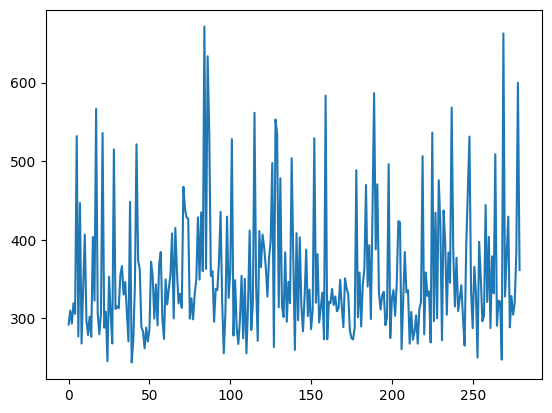

In [14]:
plt.plot(approx.hist)

In [15]:
trace = approx.sample(draws=5000)

In [16]:
with neural_network:
    pm.set_data(new_data={"ann_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


In [17]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Accuracy = 68.45238095238095%


In [18]:
X_train

array([[ 1.5951236 , -0.79059004, -0.56115686],
       [ 0.08544225, -0.62395294,  1.91257742],
       [-0.0086636 ,  2.01502272,  0.57054062],
       ...,
       [ 0.89638573, -0.82875774, -1.3257493 ],
       [-0.29029637,  2.68331237,  1.14792506],
       [-0.21558164, -0.82721909, -1.01239764]])

In [19]:
import bambi as bmb
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)

slope_mean = X_train['slope'].mean()
slope_std = X_train['slope'].std()

PP_mean = X_train['PP'].mean()
PP_std = X_train['PP'].std()

#vhs1_mean = X_train['valor_humedad_suelo1'].mean()
#vhs1_std = X_train['valor_humedad_suelo1'].std()

#X_train['slope'] = (X_train['slope'] - slope_mean) / slope_std
#X_test['slope'] = (X_test['slope'] - slope_mean) / slope_std

#X_train['PP'] = (X_train['PP'] - PP_mean) / PP_std
#X_test['PP'] = (X_test['PP'] - PP_mean) / PP_std

#X_train['valor_humedad_suelo1'] = (X_train['valor_humedad_suelo1'] - vhs1_mean) / vhs1_std
#X_test['valor_humedad_suelo1'] = (X_test['valor_humedad_suelo1'] - vhs1_mean) / vhs1_std

#X_train['PP_2'] = X_train['valor_humedad_suelo1'] / X_train['PP'] 
#X_test['PP_2'] = X_test['valor_humedad_suelo1'] / X_test['PP'] 


X_train = pd.concat([X_train, y_train], axis=1)

In [20]:
slope_mean, slope_std

(41.42002598164937, 13.117719634164368)

In [21]:
model1 = bmb.Model("output ~ (slope + PP + valor_humedad_suelo1)", X_train, family="bernoulli", link= 'logit')
fitted1 = model1.fit(draws=1000,tune=1000, idata_kwargs={"log_likelihood": True})

Modeling the probability that output==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, slope, PP, valor_humedad_suelo1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 586 seconds.


Sampling: [Intercept, PP, slope, valor_humedad_suelo1]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'slope'}>, <Axes: title={'center': 'PP'}>,
       <Axes: title={'center': 'valor_humedad_suelo1'}>], dtype=object)

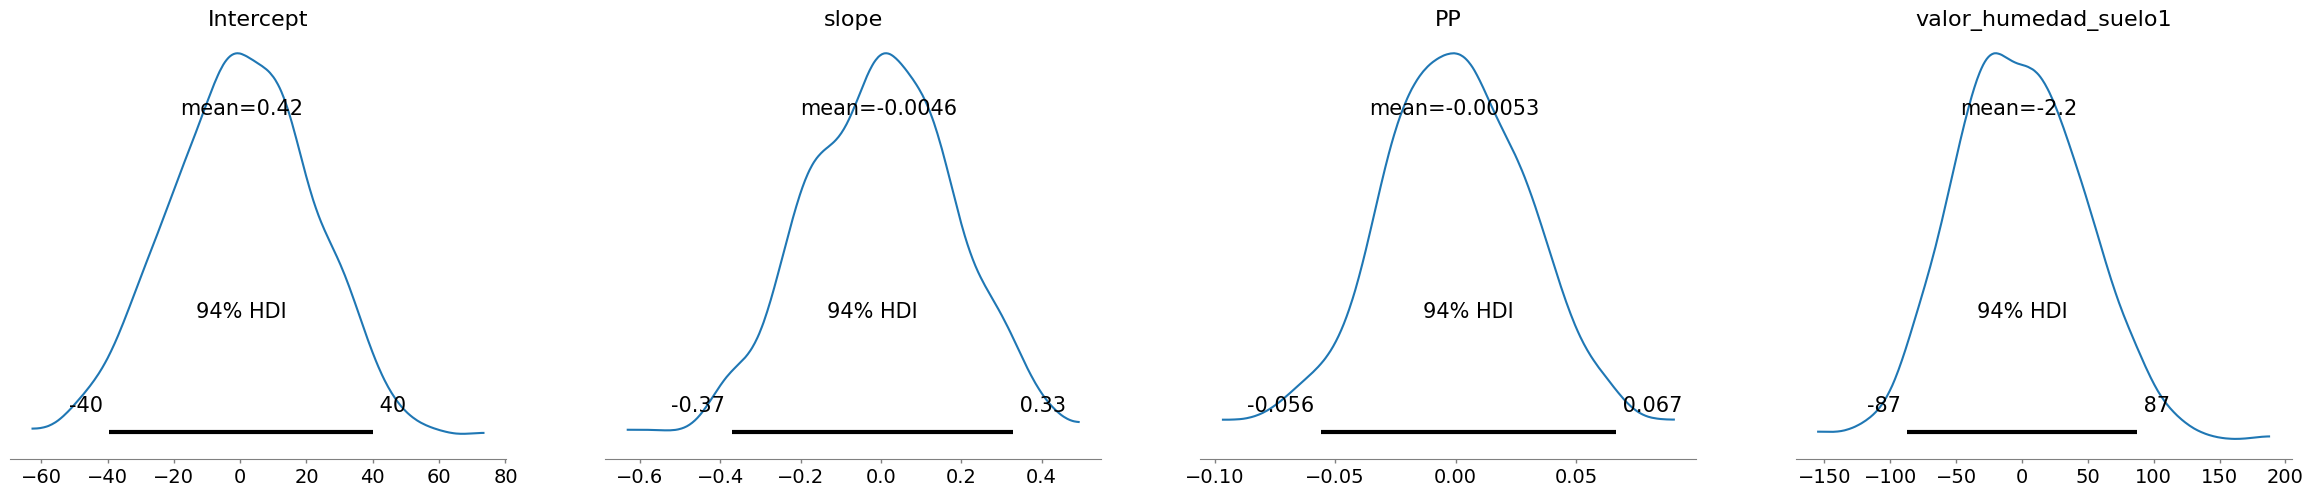

In [22]:
model1.plot_priors(draws=1000)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-10.793,1.348,-13.337,-8.260,0.020,0.015,4335.0,3076.0,1.0
slope,0.030,0.009,0.013,0.046,0.000,0.000,7096.0,3343.0,1.0
PP,-0.002,0.002,-0.005,0.000,0.000,0.000,4517.0,3478.0,1.0
valor_humedad_suelo1,23.744,3.204,17.885,29.682,0.049,0.035,4311.0,2879.0,1.0


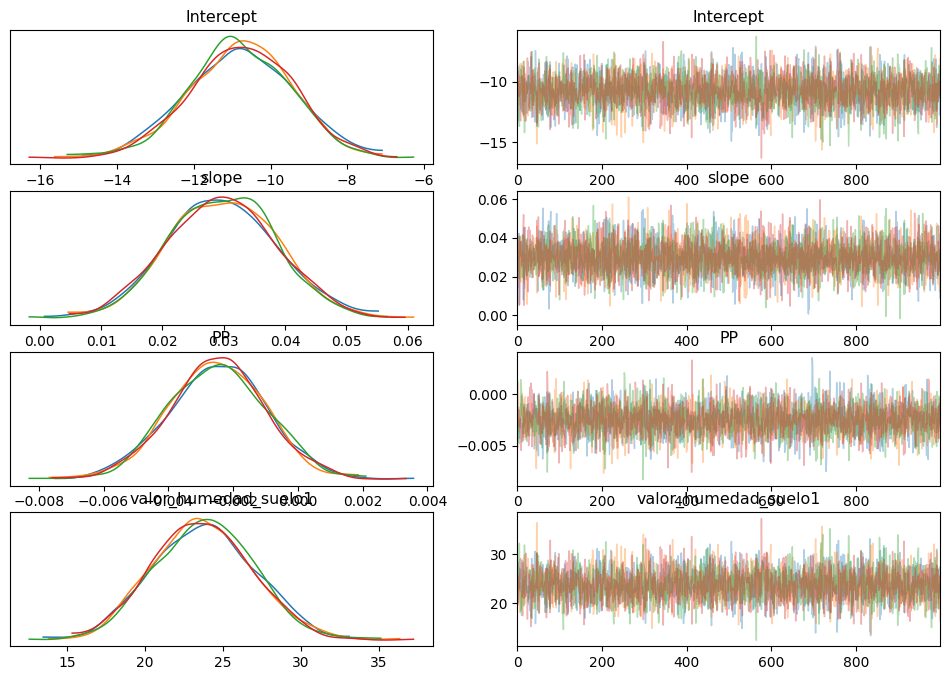

In [23]:
az.plot_trace(fitted1, compact = False);
az.summary(fitted1)

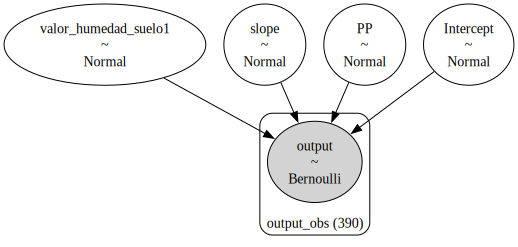

In [24]:
model1.graph()

In [25]:
pred = model1.predict(fitted1, data=X_test)
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

In [26]:
pred = fitted1.posterior['output_mean'].mean(('chain', 'draw')) > 0.5

In [27]:
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Accuracy = 80.35714285714286%


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)
# Definir el modelo en PyMC3
"""with pm.Model() as modelo_bayesiano:
    # Priors para los coeficientes
    input = pm.Data("input", X_train, mutable=True)
    output = pm.Data("output", y_train, mutable= True)
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta_slope = pm.Normal('beta_slope', mu=0, sigma=10)
    beta_PP = pm.Normal('beta_PP', mu=0, sigma=10)
    beta_humedad = pm.Normal('beta_humedad', mu=0, sigma=10)

    # Modelo lineal
    logit = beta0 + beta_slope * input['slope'] + beta_PP * input['PP'] + beta_humedad * input['valor_humedad_suelo1']

    # Likelihood
    output_observed = pm.Bernoulli('output_observed', logit_p=logit, observed=output)

    # Muestrear el modelo
    #trace = pm.sample(2000, tune=1000)

pm.model_to_graphviz(modelo_bayesiano)
"""




'with pm.Model() as modelo_bayesiano:\n    # Priors para los coeficientes\n    input = pm.Data("input", X_train, mutable=True)\n    output = pm.Data("output", y_train, mutable= True)\n    beta0 = pm.Normal(\'beta0\', mu=0, sigma=10)\n    beta_slope = pm.Normal(\'beta_slope\', mu=0, sigma=10)\n    beta_PP = pm.Normal(\'beta_PP\', mu=0, sigma=10)\n    beta_humedad = pm.Normal(\'beta_humedad\', mu=0, sigma=10)\n\n    # Modelo lineal\n    logit = beta0 + beta_slope * input[\'slope\'] + beta_PP * input[\'PP\'] + beta_humedad * input[\'valor_humedad_suelo1\']\n\n    # Likelihood\n    output_observed = pm.Bernoulli(\'output_observed\', logit_p=logit, observed=output)\n\n    # Muestrear el modelo\n    #trace = pm.sample(2000, tune=1000)\n\npm.model_to_graphviz(modelo_bayesiano)\n'

In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [30]:
def model_test(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, dims='dims_id')
        intercept = pm.Normal('intercept', mu=0,sigma=5)
        beta = pm.Normal('beta',mu=0, sigma=5)
        sigma = pm.Normal('sigma', mu=0, sigma=5)
        sigma_2 = pm.Normal('sigma_2', mu = 0, sigma=5)
        final = pm.Bernoulli('out',logit_p = intercept + input[:,0]*beta + input[:,1]*sigma + input[:,2]*sigma_2, observed = observed, dims='obs_id')
    return model

model_test = model_test(X_train, y_train)

In [31]:
with model_test:
    approx = pm.fit(n=10_000)

Finished [100%]: Average Loss = 238.77


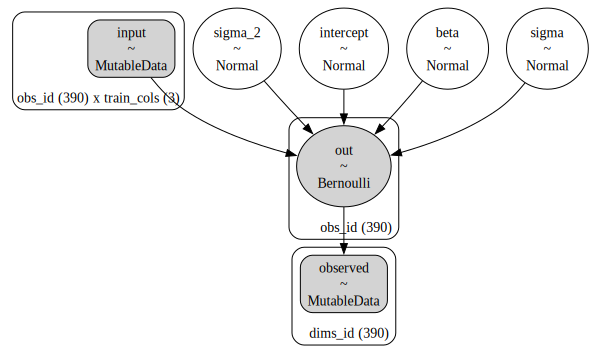

In [32]:
pm.model_to_graphviz(model_test)

In [33]:
trace = approx.sample(draws=5000)
#pred_trace = pm.sample(draws=1000,tune=1000,chains=2, cores = 6, init = 'adapt_diag')

In [34]:
with model_test:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


In [35]:
X_train.shape, X_test.shape

((390, 3), (168, 3))

In [36]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50

In [37]:
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Accuracy = 80.95238095238095%


In [38]:
def bayesian_regression_tree(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, dims='dims_id')
        intercept = pm.Normal('intercept', mu = 0, sigma = 5)
        beta = pm.Normal('beta',mu=0, sigma=5)
        beta2 = pm.Normal('beta2', mu=0, sigma=5)
        beta3 = pm.Normal('beta3', mu = 0, sigma=5)
        alpha = pm.Normal('alpha', mu = 0, sigma=0.1)
        alpha2 = pm.Normal('alpha2', mu = 0, sigma = 0.1)
        alpha3 = pm.Normal('alpha3', mu = 0, sigma=1)
        alpha4 = pm.Normal('alpha4', mu = 0, sigma = 0.1)
        alpha5 = pm.Normal('alpha5', mu = 0 , sigma = 1)
        alpha6 = pm.Normal('alpha6', mu = 0 , sigma = 1)
        p = pm.Deterministic(
            'p', 
            pm.math.invlogit(
                intercept + input[:,0]*beta + input[:,1]*beta2 + input[:,2]*beta3)) #+ 
                #(input[:,1]**2)*alpha**2 + (input[:,2]**2)*alpha2**2 + (input[:,0]**2)*alpha3**2 + 
                #(input[:,1]**2)*alpha4**3 + (input[:,2]**2)*alpha5**3 + (input[:,0]**2)*alpha6**3))
        final = pm.Bernoulli('out',p , observed = observed, dims='obs_id')
        
    return model

bayesian_regression_tree = bayesian_regression_tree(X_train, y_train)

In [ ]:
with bayesian_regression_tree:
    start = pm.find_MAP()
    #hessian_inv = np.linalg.inv(pm.find_hessian(start, model=bayesian_regression_tree))
    #approx = pm.fit(n=10_000, start=start)
    trace = pm.sample(draws=5000, start = start)# nuts_sampler_kwargs={'hess_inv': hessian_inv})

with bayesian_regression_tree:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace, var_names=['p'], return_inferencedata=True, predictions=True, extend_inferencedata=True)
    trace.extend(ppc)
#pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
pred = ppc.predictions['p'].mean(('chain', 'draw')) > 0.5
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

C:\Users\ivo\AppData\Local\Temp\ipykernel_17940\1382535278.py:5: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(draws=5000, start = start)# nuts_sampler_kwargs={'hess_inv': hessian_inv})
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, beta2, beta3, alpha, alpha2, alpha3, alpha4, alpha5, alpha6]


In [ ]:
pm.model_to_graphviz(bayesian_regression_tree)

In [ ]:
trace = approx.sample(draws=5000)
with bayesian_regression_tree:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace, var_names=['p'], return_inferencedata=True, predictions=True, extend_inferencedata=True)
    trace.extend(ppc)
#pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
pred = ppc.predictions['p'].mean(('chain', 'draw')) > 0.50
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

In [ ]:
az.summary(ppc)

In [ ]:
import pymc_bart as pmb
def bayesian_bart(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, dims='dims_id')
        sigma = pm.HalfNormal('sigma', 0.5)
        mu = pmb.BART('mu', input.get_value(), observed.get_value(), m=50)
        out = pm.Normal('out', mu,sigma, observed=observed)
        #out = pm.Bernoulli('y_pred', mu, observed= observed)
      
        
    return model

bayesian_bart = bayesian_bart(X_train, y_train)


In [ ]:
with bayesian_bart:
    approx = pm.fit(n=10_000)

In [ ]:
trace = approx.sample(draws=5000)

In [ ]:
with bayesian_bart:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)
#pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
#pred = ppc.predictions['out'].mean(('chain', 'draw')) > 0.50
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

In [ ]:
with pm.Model() as bayesian_bart_model:
    input = pm.Data('input', X_train, mutable=True)
    observed = pm.Data('observed', y_train, mutable=True)
    sigma = pm.HalfNormal('sigma', 0.5)
    mu = pmb.BART('mu', input.get_value(), observed.get_value(), m=50)
    out = pm.Normal('out', mu,sigma, observed=observed)
#    idata_posterior = pm.sample()
#    posterior_predictive_bart_model = pm.sample_posterior_predictive(trace = idata_posterior)

In [ ]:
trace = approx.sample(draws=5000)
with bayesian_bart:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace)#return_inferencedata=True, predictions=True, extend_inferencedata=True)
    trace.extend(ppc)
    
#pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
#pred = ppc.predictions['out'].mean(('chain', 'draw')) > 0.50
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

In [ ]:
with pm.Model() as model_2:
    pred = pm.MutableData("pred", X_train)
    σ = pm.HalfNormal("σ", y_train.std())
    μ = pmb.BART("μ", pred.get_value(), y_train, m=50)
    y = pm.Normal("y", μ, σ, observed=y_train)
    idata_2 = pm.sample(random_seed=42)

In [ ]:
with pm.Model() as model_oos_regression:
    X = pm.MutableData("X", X_train)
    Y = y_train
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, Y)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y, shape=μ.shape)
    idata_oos_regression = pm.sample()
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression)